# 회귀분석 실습 2
## 공공 자전거 수요 예측(Bike Sharing Demand)

###https://www.kaggle.com/c/bike-sharing-demand/overview

 - 데이터 소개
  - 날짜 및 시간, 기온, 습도, 풍속 등의 정보를 정보를 
  
  기반으로 1시간 간격으로 자전거 대여 횟수를 기록한 데이터.
  - 기록 날짜는 2011년 1월 ~ 2012년 12월까지
  - 데이터에 자세한 정보는 소개된 캐글 사이트에서 확인 가능.


### Data Fields
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +  Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

1. 데이터 불러오기

In [54]:
import calendar
import numpy as np
import pandas as pd
# from pandas.core.frame imort DAtaFrame
# from pandas.core.series import Series 로 불러도 상관없음
import seaborn as sns # 통계적 plot
from scipy import stats # 통계
import missingno as msno # 결측치 보는 plot
from datetime import datetime # day
import matplotlib.pyplot as plt
import warnings # 에러는 아닌데 주의 뜨는 것 방지
warnings.filterwarnings('ignore')

df_train=pd.read_csv('C:/Users/405/my_study/Python_Study/0511/train.csv')
df_test=pd.read_csv('C:/Users/405/my_study/Python_Study/0511/test.csv')


2. 데이터 정보 확인

In [55]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [56]:
df_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [57]:
print(df_train.shape, df_test.shape)

(10886, 12) (6493, 9)


In [58]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [59]:
df_train.info() # datatime : object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [60]:
df_train['datetime'] # 0번째 : 2011-01-01[0] 00:00:00[1]

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [61]:
df_train['date']=df_train.datetime.apply(lambda x:x.split()[0]) # split은 스페이스 중심
df_train['hour']=df_train.datetime.apply(lambda x:x.split()[1].split(':')[0])
# 날짜와 시간정보를 " " 사이로 쪼개서 새로운 칼럼으로 추가
df_train["weekday"] = df_train.date.apply(lambda dateString : calendar.day_name[
    datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df_train["month"] = df_train.date.apply(lambda dateString : calendar.month_name[
    datetime.strptime(dateString,"%Y-%m-%d").month])
df_train["season"] = df_train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
df_train["weather"] = df_train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [62]:
df_train.info() # object으로 뜸 카테고리로 변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  date        10886 non-null  object 
 13  hour        10886 non-null  object 
 14  weekday     10886 non-null  object 
 15  month       10886 non-null  object 
dtypes: float64(3), int64(6), object(7)
memory usage: 1.3+ MB


In [63]:
categoryVariablesList=['hour','weekday','month', 'season','weather','holiday','workingday']
for var in categoryVariablesList:
    df_train[var]=df_train[var].astype('category')

In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season      10886 non-null  category
 2   holiday     10886 non-null  category
 3   workingday  10886 non-null  category
 4   weather     10886 non-null  category
 5   temp        10886 non-null  float64 
 6   atemp       10886 non-null  float64 
 7   humidity    10886 non-null  int64   
 8   windspeed   10886 non-null  float64 
 9   casual      10886 non-null  int64   
 10  registered  10886 non-null  int64   
 11  count       10886 non-null  int64   
 12  date        10886 non-null  object  
 13  hour        10886 non-null  category
 14  weekday     10886 non-null  category
 15  month       10886 non-null  category
dtypes: category(7), float64(3), int64(4), object(2)
memory usage: 842.1+ KB


- 결측치 확인

In [65]:
df_train.isnull().sum()
# df_train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

<Axes: >

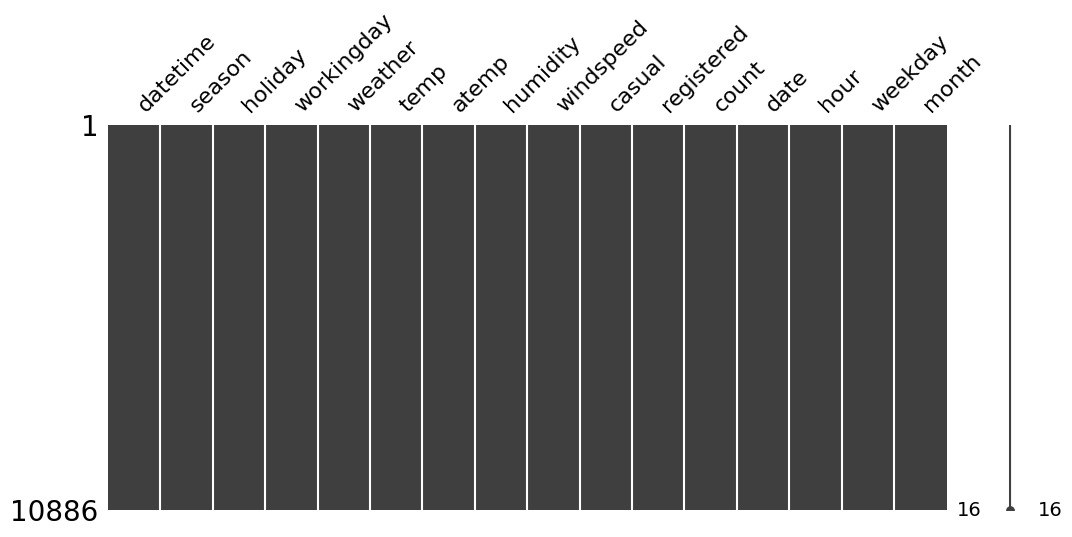

In [66]:
import missingno as msno # 결측치 보는 plot
msno.matrix(df_train, figsize=(12,5))
# 결측치가 있다면 하얀색 줄이 그어짐.

In [70]:
df_train_1=df_train.copy()
df_test_1=df_test.copy() # 훼손 방지하기 위해 카피

df_train_1['datetime']=pd.to_datetime(df_train_1['datetime'])

In [71]:
type(df_train_1)

pandas.core.frame.DataFrame

In [73]:
# DataFrame 가능한 것
df_train_1['year']=df_train_1['datetime'].dt.year
df_train_1['month']=df_train_1['datetime'].dt.month
df_train_1['day']=df_train_1['datetime'].dt.day
df_train_1['hour']=df_train_1['datetime'].dt.hour
df_train_1['minute']=df_train_1['datetime'].dt.minute
df_train_1['second']=df_train_1['datetime'].dt.second
# 요일데이터 _ 일요일은 0
df_train_1['dayofweek']=df_train_1['datetime'].dt.dayofweek